In [1]:
%%capture
# The above line blocks annoying comments from Pygame. It has to stay at the very top of this block.

# Initial Setup
%matplotlib inline
from jupyter_scrn import *
from sklearn.metrics import mean_squared_error
from lbl_crn.homogenous_crn.solution import Solution
from lbl_crn.homogenous_crn.species import SpeciesManager, Orbital
from lbl_crn.homogenous_crn.crn_sym import RxnSystem, Rxn, RevRxn 
import lbl_crn.homogenous_crn.xps as xps

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('xtick', labelsize=36)
mpl.rc('ytick', labelsize=36) 

import pandas as pd

## Step 1 Name this Run of the Simulator

First, make sure you've run the code block above.

Define the name of the directory to store the results by changing `RESULTS_PATH` and `RUN_NUM`. `RESULTS_PATH` will store things you have on the machine. `RUN_NUM` part of the directory name differentiates the different runs of the same simulation.

Set `DEV_MODE` to `True` till you're satisfied with the figures. Then set it to `False`, take a rest, and wait for much smoother graphs.

If `DEV_MODE` is set to `False`, `REPETITIONS` will tell the Surface CRN to run the system multiple times and output the averaged results. The Surface CRN will use a 20 by 20 grid.

In [2]:
RUN_NUM = 3

DEV_MODE = True

REPETITIONS = 10

if DEV_MODE:
    grid_annotation = "10 by 10"
else:
    grid_annotation = "10 by 10"
    
    
RESULTS_PATH = "High Pressure Results 3{}rd Run - {} Grid".format(RUN_NUM, grid_annotation)


try:
    os.mkdir(RESULTS_PATH)
except OSError:
    print ("Creation of the directory {} failed".format(RESULTS_PATH))    

Creation of the directory High Pressure Results 33rd Run - 10 by 10 Grid failed


## Step 2 Define the Reaction System

Supply the reaction rules. Be sure to double check that the rates are correct.

You may change random number seed `rng_seed` once in a while. The Surface CRN is probabilistic; changing the random number seed may have some effect on the final results.

In [3]:
rules = """
# Run settings
pixels_per_node    = 50
speedup_factor     = 0.5
debug              = True
rng_seed           = 923123122
max_duration       = 10000
fps                = 60
node_display       = text
wrap               = false

!START_TRANSITION_RULES
# Condition 2:
# Temperature = 298K, Pressure = 1E-1 torr = 1.33E-1 mbar
# Binding energy:  
# H2O* = 532.2
# OH* = 530.9 
# O* = 530.0
# H2O_OH_hb = 531.6
# H2O_O_hb = 531.6
# H2Omulti = 533.2

(3.207654) O*_3F -> H2O_O_hb
(1.363342) OH*_3F -> H2O_OH_hb

 
(6.220646) H2O_O_hb + Ni -> OH*_3F + OH*_3F
(0.160755) OH*_3F + OH*_3F -> H2O_O_hb + Ni

(0.299507) H2O_OH_hb + Ni -> H2O* + OH*_3F 
(0.167130) H2O_O_hb + Ni -> H2O* + O*_3F 
# Main reaction 1
(1.939313) H2O* -> Ni
(0.515646) Ni -> H2O*

# Desorption
(0.733491) H2O_OH_hb ->  OH*_3F
(0.311754) H2O_O_hb ->  O*_3F

# Adsorption

# Comment on the results: 
# The trouble is here! These two rules specificy that there should be slightly more H2Omulti
# than H2O_OH_hb

(1.038423) H2O_OH_hb  ->  H2Omulti
# Desorption
(0.962999) H2Omulti -> H2O_OH_hb


(0.002342) O*_3F + O*_3F ->   3F + 3F
# Main reaction 2
(426.922895) 3F + 3F -> O*_3F + O*_3F

# Additional diffusion specific for the surface CRN
(3) 3F + O*_3F -> 3F + O*_3F
(3) 3F + OH*_3F -> 3F + OH*_3F
(3) Ni + H2O* -> Ni + H2O*

# The following rules are specific for the 3F sites.
(10) OH*_top + 3F -> Ni + OH*_3F
(0.5) Ni + OH*_3F -> OH*_top + 3F

(10) O*_top + 3F -> Ni + O*_3F
(0.5) Ni + O*_3F -> O*_top + 3F

!END_TRANSITION_RULES

# Initial state
!START_INIT_STATE
# TO BE HARD CODED AND RETURNED BY CODE
Ni Ni
!END_INIT_STATE

# Colormap
!START_COLORMAP
Ni: (160,160,160)
{Intersection}   I: (200, 200, 0)
!END_COLORMAP
"""


# We need our own custom grid!

In [4]:
def save_rules(rules, filename="tmp_reaction_rules.txt"):
    """
    Save the rules defined here as a text file. 
    
    Replace calls to this function with your filename if you already have a text file in the same 
    directory as this notebook.
    """
    with open(filename,"w") as f:
        f.write(rules)
    return filename

rules_file = save_rules(rules, "{}/{}.txt".format(RESULTS_PATH, "reaction_rules"))

In [5]:
rules_file = "Example Reaction Rules/high_pressure_reaction_rules.txt"

Feel free to edit the reaction rules elsewhere. In that case, we need only the filename here.

## Step 3 Customize the Surface

The Surface CRN defaults to a square grid that you could have defined as the `rules` variable above or in a separate `txt` file. The grid should also represent where the initial species are located. 

If you'd like to define a different surface structure, hard code the structure here.

In [6]:
def produce_initial_surface():
    """
    Returns a hard-coded surface for the reaction, populated with initial concentrations.
    
    This will replace the initial state supplied in the text file (a.k.a. the file for rules).
    """
    
    # Initiate the default surface structure. In general, a 10 by 10 grid can be simulated in 1 minute; 
    # a 20 by 20 grid will take some wait, but the resulting spectrum is much smoother.
    if DEV_MODE:
        surface = HexGridPlusIntersections(10, 10)
    else:
        surface = HexGridPlusIntersections(20, 20)
    surface = HexGridPlusIntersections(10, 10)
    
    # Popultate the structure with initial atoms.     
    for n in surface:
        if n.is_intersection:
#             if random.random() < 0.25:
#                 n.state = "O*_3F"
#             else:
            n.state = "3F"
        else:
            if random.random() < 0.25:
                n.state = "O*_top"
            else:
                n.state = "Ni"
    return surface

surface = produce_initial_surface()

## Step 4 the Secret Sausage

Run the Surface CRN. You need to give it a list of species to track.

In [7]:
species = ["H2Omulti", "H2O*", "H2O_O_hb", "H2O_OH_hb", "O*_3F", "O*_top", "OH*_3F", "OH*_top"]

In [8]:
%%capture
# The above line suppresses the Surface CRN's printing of the initial setup as it understands it. It has to
# be the very first line of this block.
# These messages may come of use if you suspect the Surface CRN is understanding your input in the wrong
# way.

if DEV_MODE:
    times, concs = simulate_without_display(rules_file, surface, species)

In [9]:
def simulate_multiple_times(rules_file, surface_func, species, rep_count=1):
    all_times, all_concs = [], []
    for _ in range(rep_count):
        times, concs = simulate_without_display(rules_file, surface_func(), species)
        all_times.append(times)
        all_concs.append(concs)
    return all_times, all_concs


def average_multiple_runs(all_times, all_concs, time_resolution=0.1):
    """
    Run the Surface CRN multiple times and generate an averaged time series from rep_count number of runs. For each
    run, use surface_func to generate a distinct initial condition.
    
    The Surface CRN uses uneven time steps and outputs a series of time steps as parts result. The time_resolution 
    variable regularizes the time steps across different runs of the simulation, by specifying the length of 
    a time interval.
    
    This function will average the molecular counts of each species during each time interval.
    """
#     assert len(all_times) = len(all_concs), "The number of time sequences is not equal to the number of concs dictionaries."
    
    min_effective_time = min([ts[-1] for ts in all_times])
    resulting_times = np.arange(time_resolution, min_effective_time + time_resolution, time_resolution)
    
    all_results = [[] for _ in range(len(species))]
    
    rep_count = len(all_times)

    for rep_i in range(rep_count):
        times, concs = all_times[rep_i], all_concs[rep_i]
        
        run_results = [[] for _ in species]
        
        time = time_resolution
        
        i, counts, num = 0, [0 for _ in species], 0
        
        # The index for the time interval where there is a valid molecular count.
        last_valid_index = 0
        resulting_times_index = 0
        time = resulting_times[resulting_times_index]
        while time <= min_effective_time and i < len(times):
            if times[i] < time:
                counts = [counts[si] + concs[species[si]][i] for si in range(len(species))]
                num += 1
            else:
                for si in range(len(species)):
                    l_last_valid_index = last_valid_index
                    if num != 0:
                        # Fill in the missing Nones, if appropriate:
                        if l_last_valid_index + 1 != len(run_results[si]):
#                             print(last_valid_index, len(run_results[si]))

                            
                            if l_last_valid_index == 0 and len(run_results[si]) == 0:
                                missing_value = counts[si] / num
                            elif l_last_valid_index == 0 and run_results[si][l_last_valid_index] is None:
                                missing_value = counts[si] / num
                            else:
                                missing_value =  (run_results[si][l_last_valid_index] + counts[si] / num) / 2
                            
                            while l_last_valid_index < len(run_results[si]):
                                print("filling in missing values", missing_value)
                                
                                run_results[si][last_valid_index] = missing_value
                                l_last_valid_index += 1
                            
                            run_results[si].append(counts[si] / num)
                            assert l_last_valid_index + 1 == len(run_results[si])
                        else:
                            run_results[si].append(counts[si] / num)
                            l_last_valid_index += 1
                        
                    else:
                        if i == len(times) - 1:
                            # The loop is about to terminate. Fill in all Nones with last available value.
                            missing_value =  run_results[si][l_last_valid_index]
                            while l_last_valid_index < len(resulting_times):
                                run_results[si][last_valid_index] = missing_value
                                l_last_valid_index += 1
                            
                        elif len(run_results[si]) != 0:
                            run_results[si].append(None) 
                            
                        else:
                            run_results[si].append(None)
                
                resulting_times_index += 1                            
                time = resulting_times[resulting_times_index]
                counts, num = [0 for _ in species], 0
                
                last_valid_index = l_last_valid_index
            i += 1
            
            
        print("their are this many time steps in this run", len(times))    
            
        print("last time in times: ", times[-1])
    
        print("Time till very last", time)
        print("Min effecitive time", min_effective_time)
        
        
        print(run_results)
        
        while time <= min_effective_time:
            # No real values can be obtained for this time interval. Use the molecular counts from last available time stamp.
            
            for si in range(len(species)):
                print(len(run_results[si]))
                print(last_valid_index)
                if len(run_results[si]) != 0:
                    run_results[si].append(run_results[si][last_valid_index])
                else:
                    run_results[si].append(run_results[si][last_valid_index])
        
            resulting_times_index += 1                            
            time = resulting_times[resulting_times_index]
            
#         if len(resulting_times) < time_steps:
#             min_resulting_times = resulting_times
#             time_steps = len(min_resulting_times)
        
        
#         # For time intervals where there's no simulation run, the following block finds and average
#         # betwee the previous and the next time intervals with simulated results.
#         for si in range(len(species)):
#             conc = run_results[si]
#             print("The results are this long: {}".format(len(conc)))
            
#             i = 0
#             while i < len(resulting_times):
            
#                 if conc[i] is None:
#                     if i > 0 and i + 1 < len(conc) and conc[i + 1]:
#                         conc[i] = (conc[i - 1] + conc[i + 1]) / 2
#                     elif i + 1 == len(conc):
#                         conc[i] = conc[i - 1]
#                     else:
#                         # Go find next value that's not none.
#                         j = i
#                         while j < len(resulting_times) and conc[j] is None:
#                             j += 1
#                         if j == len(resulting_times):
#                             m = i
#                             while conc[m] is None and m >= 0:
#                                 m -= 1
#                             while i < len(resulting_times):
#                                 conc[i] = conc[m]
#                                 i += 1

#                         else:
#                             while i < j:
#                                 conc[i] = conc[j]
#                                 i += 1
#                 i += 1
            all_results[si].append(np.array(conc))
    
    all_results = [np.array(all_results[si]) for si in range(len(species))]
        
    print(all_results)
    final_concs = {}    
    for si in range(len(species)):
        
        print(all_results[si], len(resulting_times))
        all_results[si].shape
        final_concs[species[si]] = np.average(all_results[si][:len(resulting_times), :], axis=0).tolist()
                        
    return resulting_times.tolist(), final_concs

In [10]:
# %%capture
if not DEV_MODE:
#         times, concs = simulate_without_display(rules_file, surface, species)
    all_times, all_concs = simulate_multiple_times(rules_file, produce_initial_surface, species, rep_count=2)

In [11]:
if not DEV_MODE:
    average_multiple_runs(all_times, all_concs)

## Step 5 The Results and the Art of Plotting

Now sum up all the subspecies into a seperate entry in `concs`.

In [12]:
# A dictionary from a species to its subspecies.
sub_species_dict = {"H2O_hb": ["H2O_O_hb", "H2O_OH_hb"], "OH*":  ["OH*_top", "OH*_3F"], 
                    "O*":  ["O*_top", "O*_3F"]}

def sum_sub_species(concs, sub_species_dict):
    """
    Produce the total concentration for each species in sub_species_dict.
    
    Append the resulting series of total concentration to concs.
    """
    for k, v in sub_species_dict.items():
        conc = []
        for i in range(len(list(concs.values())[0])):
            c = 0
            for species in v:
                c += concs[species][i]
            conc.append(c)
        concs[k] = conc
        
sum_sub_species(concs, sub_species_dict)

Specify the species you'd like to display and the colors for each of them.

The plotter will plot with all species from the `species_in_figure` list, and then with all but the first species. This way, you may clearly see how species with way smaller molecular counts evolve over time.

In [13]:
# A list of species to display, best by the order of rough concentration levels. Species that are orders
# of magnitude more should be in the front.
species_in_figure = ["O*", "H2O*", "OH*", "H2O_hb", "H2Omulti"]
# Colors to use for each species, 1st color is for the 1st species, etc.
spanish_grey, fire_engine_red = "#989898", "#CE2029"
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',  fire_engine_red, spanish_grey, '#bcbd22', '#17becf']

You can calculuate the order of species by final concentration values here and then make modifications to `species_in_figure`. 

In [14]:
def rank_by_final_value(concs):
    """
    Return a list of species ranked by their final concentration value.
    
    Final concentration, for the purposes here, is defined as the average of the last 100 values in a time series.
    """
    species = list(concs.keys())
    species.sort(reverse=True, key=lambda k: sum(concs[k][-100:]) / 100)
    return species

rank_by_final_value(concs)

['H2O_hb',
 'H2O_O_hb',
 'O*',
 'O*_top',
 'OH*',
 'OH*_top',
 'H2Omulti',
 'O*_3F',
 'H2O_OH_hb',
 'OH*_3F',
 'H2O*']

In [15]:
species_in_figure = ['O*', 'H2O_hb','H2Omulti', 'OH*', 'H2O*']

In [16]:
def plot(concs, times, name="Entire Reaction", end_time=-1):
    """
    Plot the concentrations until time step end_time. -1 means till the end.
    
    Name is the specifc name of this plot.
    """
    if end_time == -1:
        end_step_num = len(times)
    else:
        end_step_num = 0
        while end_step_num < len(times) and times[end_step_num] < end_time:
            end_step_num += 1
        
    
    fig = plt.figure(figsize=(50,100))
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Evolution of H2O on Ni(111) System {}".format(name), fontsize=48)
    for i in range(len(species_in_figure) - 1):
        plt.subplot(len(species_in_figure) , 1, i + 1)
        for j in range(i, len(species_in_figure)):
            species = species_in_figure[j]
            plt.plot(times[:end_step_num], concs[species][:end_step_num], colors[j], label=species, linewidth=5)
            plt.legend(fontsize=36, numpoints=30)

        plt.xlabel("Time (s)", fontsize=36)
        plt.ylabel("Molecule Count (#)", fontsize=36)

    fig.savefig("{}/{}".format(RESULTS_PATH, name))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


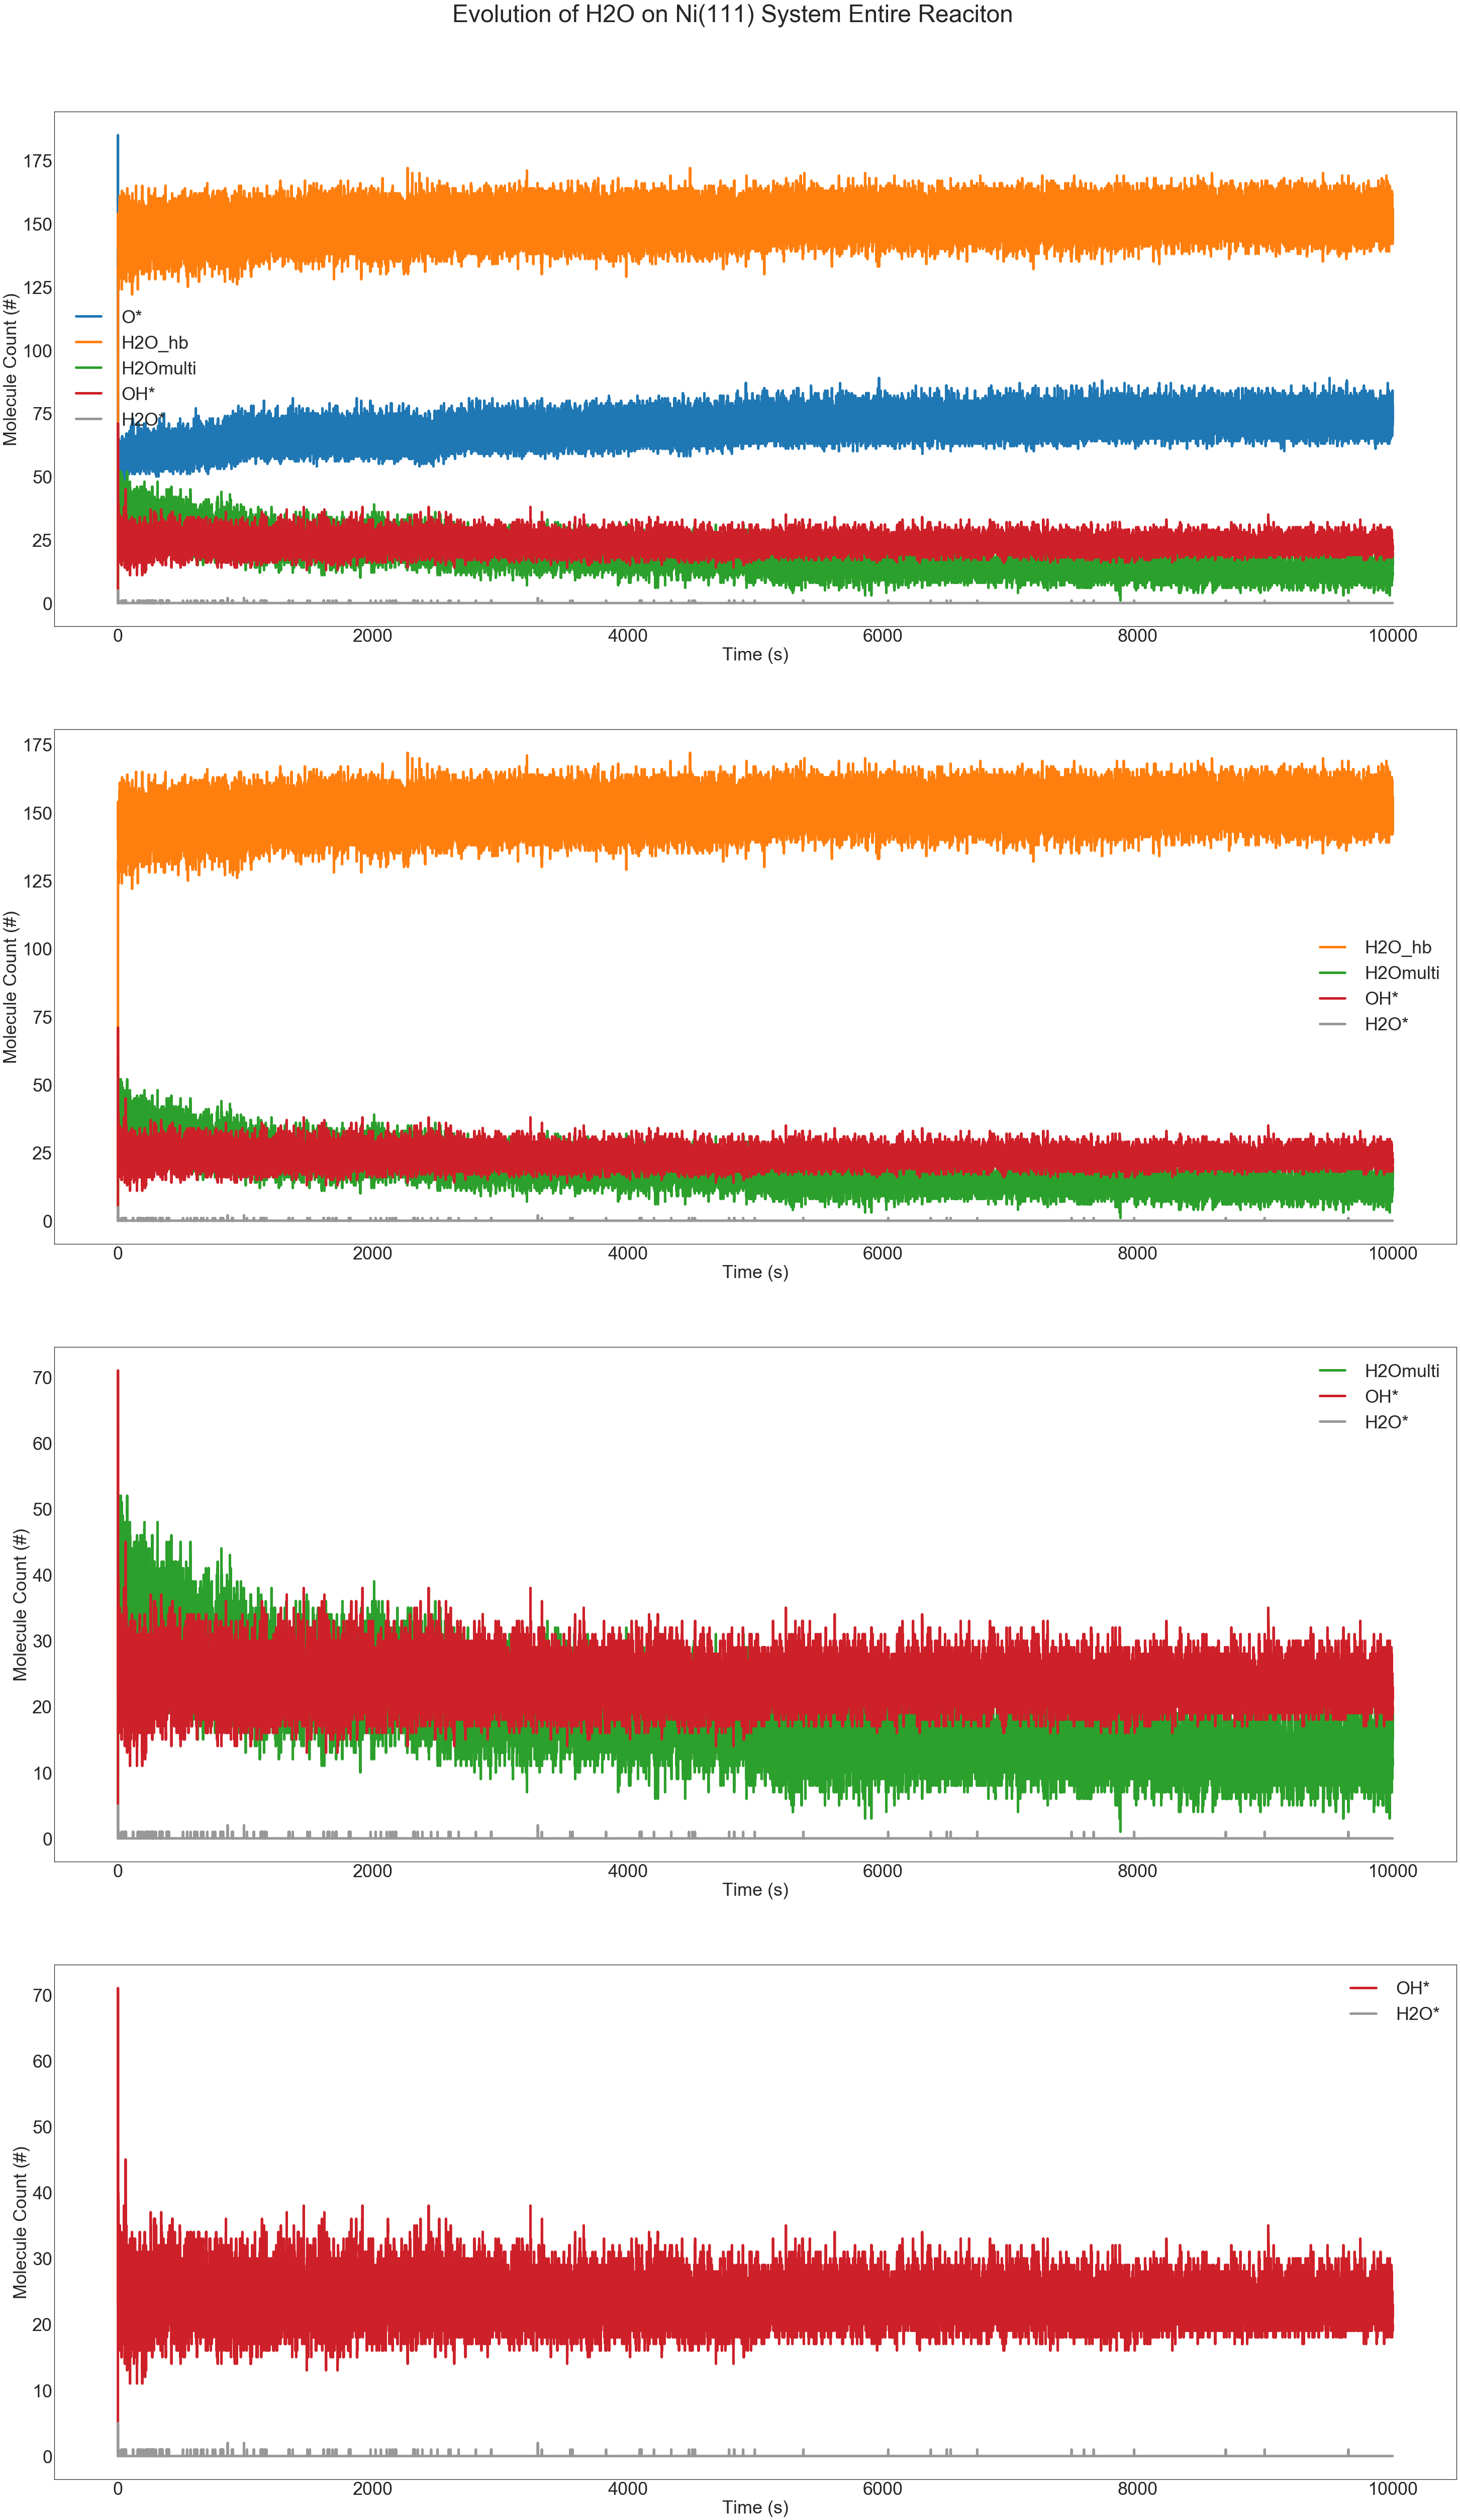

In [17]:
plot(concs, times, name="Entire Reaciton")

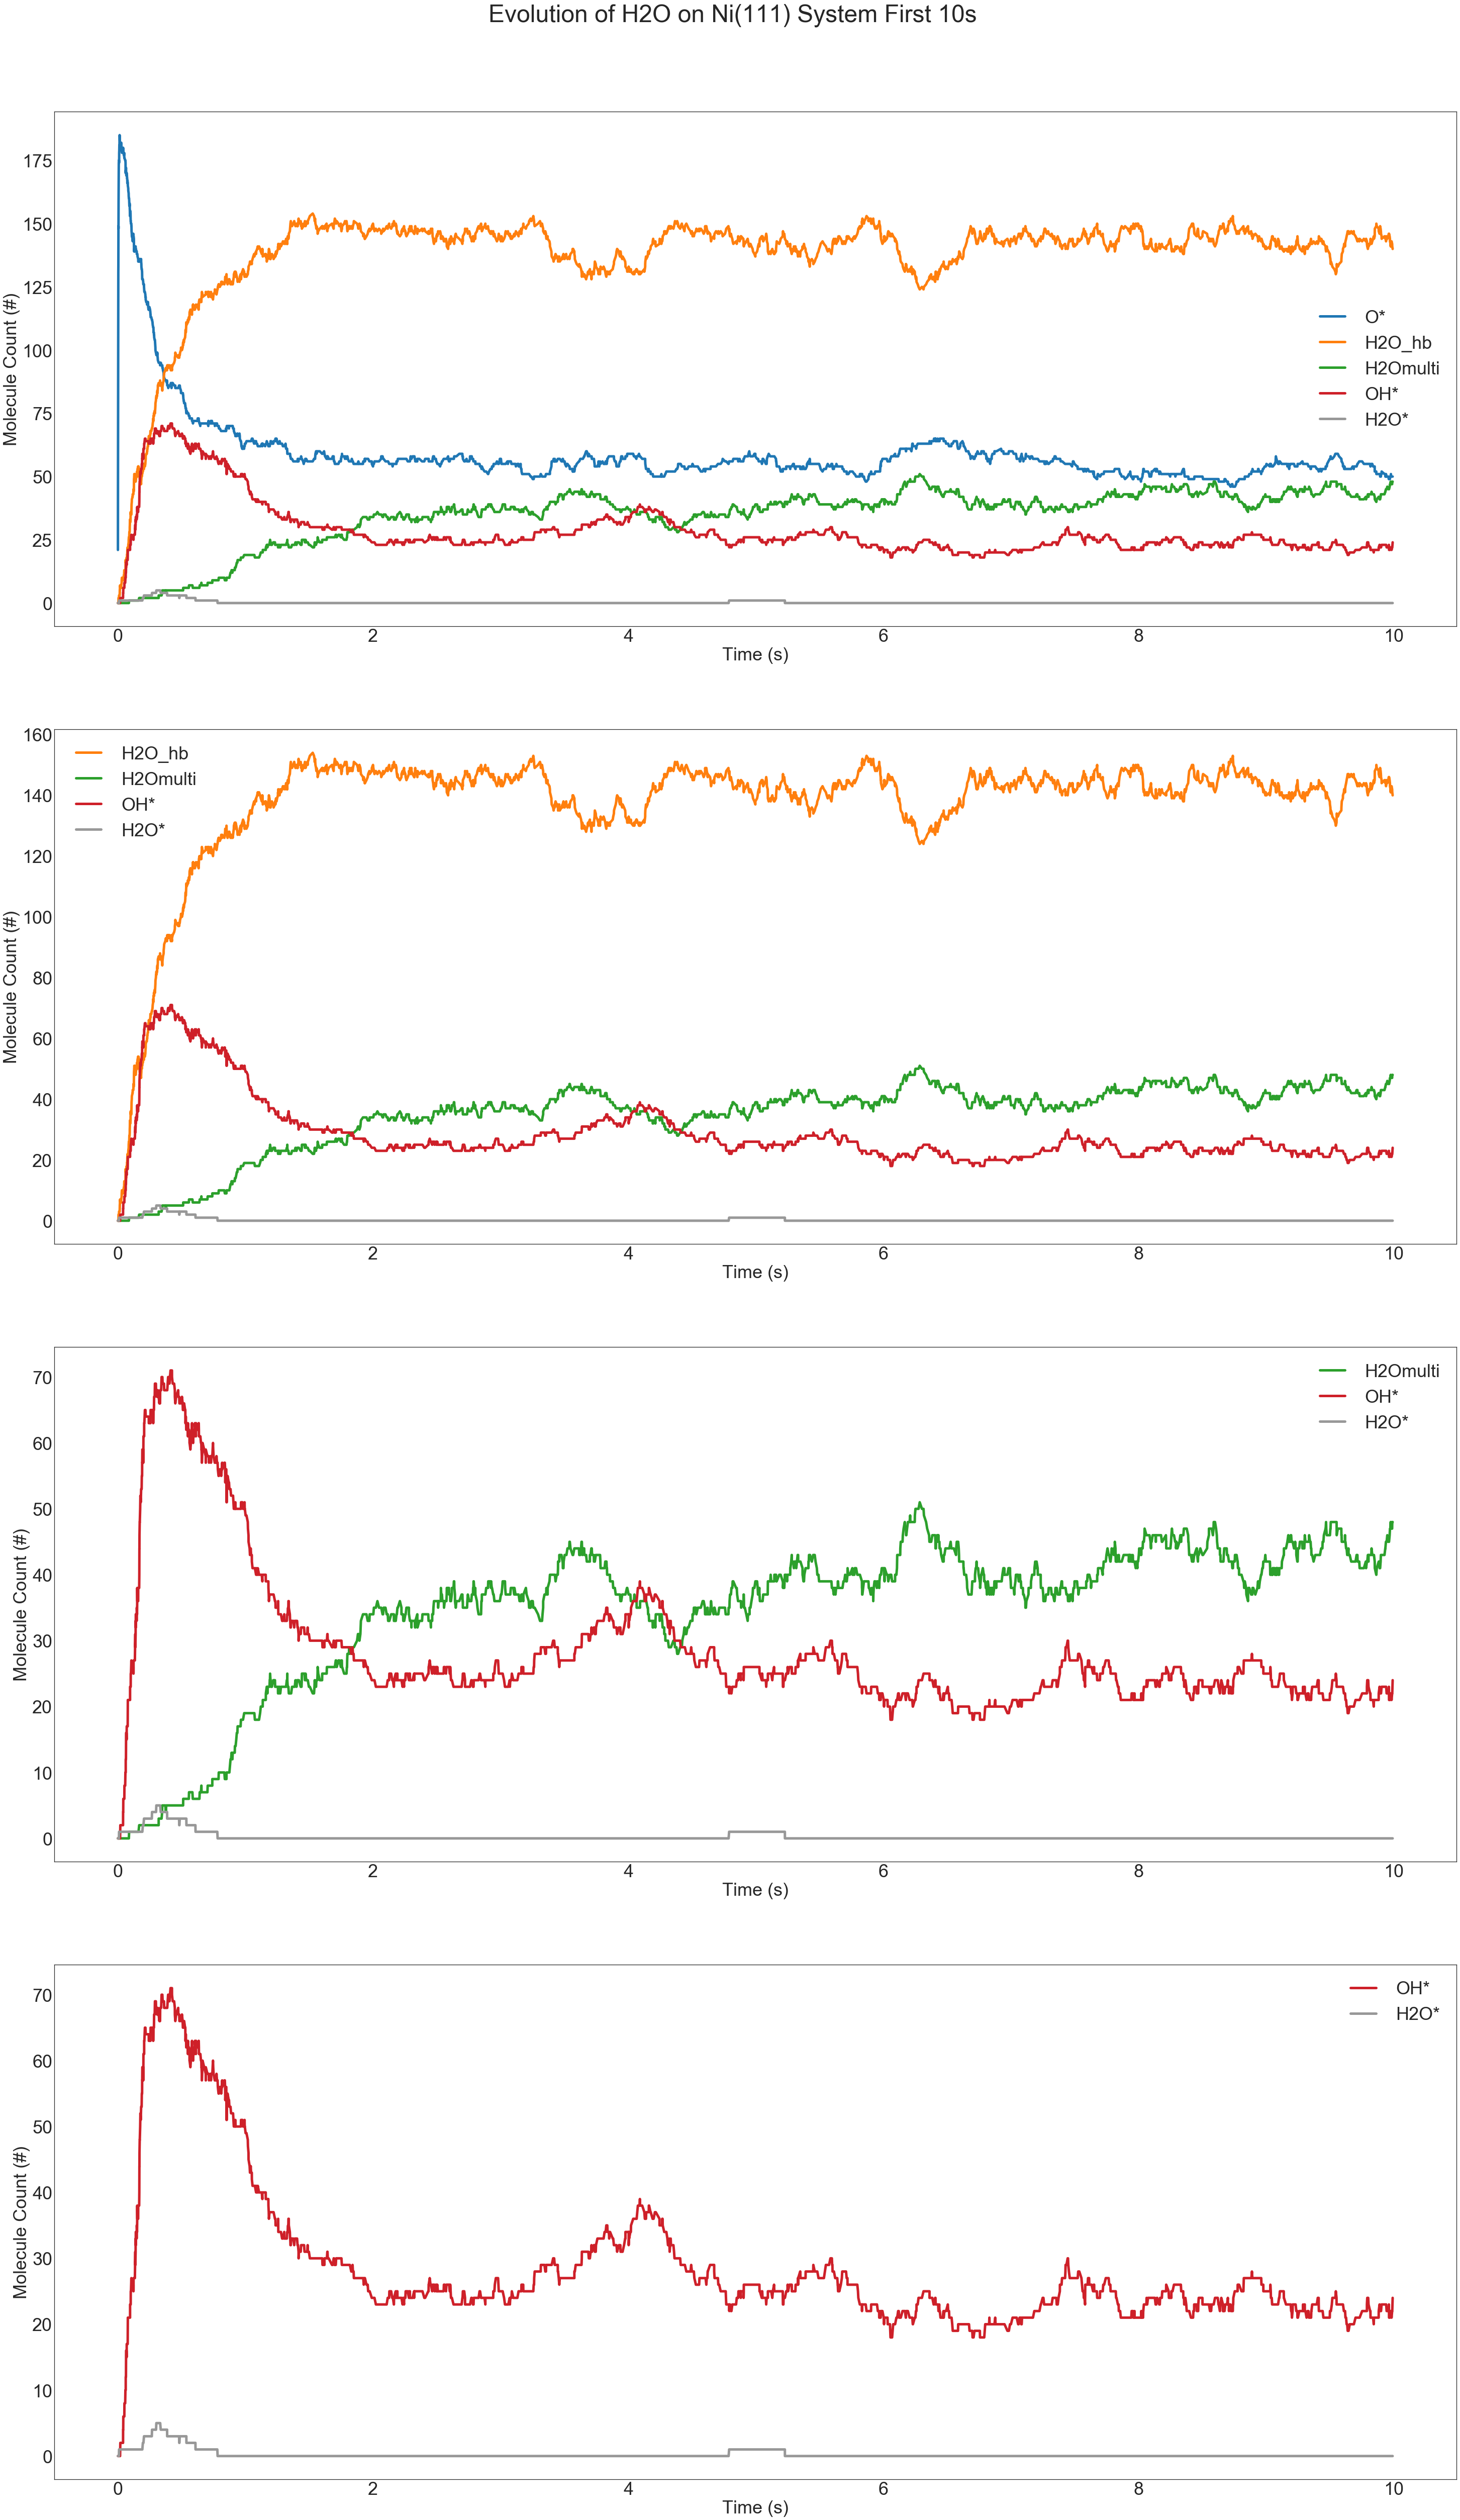

In [18]:
plot(concs, times, name="First 10s", end_time=10)

Now, we save the data for any future use.

In [19]:
df = pd.DataFrame.from_dict(concs)
df.insert(0, "Time (s) ", times)
df.to_csv("{}/Data".format(RESULTS_PATH))

## Step 5 Optional: Save the final values

Observe the figures in Step 4 and define a time after which the molecular counts for all species converge. 

In [20]:
CONVERGENCE_TIME = 9800

In [21]:
def compute_converged_values(times, concs, t):
    """
    Average all the values after time step t.
    """
    i = len(times) - 1
    while i >= 0 and times[i] > t:
        i -= 1
        
    averaged_results = {}
    for k, v in concs.items():
        averaged_results[k] = sum(v[i:]) / (len(times) - i)
    
    return averaged_results

In [22]:
final_values = compute_converged_values(times, concs, CONVERGENCE_TIME)
final_values

{'H2Omulti': 12.685107376283847,
 'H2O*': 0.0,
 'H2O_O_hb': 141.37896825396825,
 'H2O_OH_hb': 11.797346716464364,
 'O*_3F': 13.625311235605354,
 'O*_top': 59.0,
 'OH*_3F': 6.508986928104576,
 'OH*_top': 17.0,
 'H2O_hb': 153.17631497043263,
 'OH*': 23.508986928104576,
 'O*': 72.62531123560535}

A `csv` file for this set of final values is saved in `RESULTS_PATH/Final Values`

In [23]:
df = pd.DataFrame(final_values.items(), columns=['Species', 'Molecular Count'])
df.to_csv("{}/Final Values".format(RESULTS_PATH))

## Step 6: Comparison with Experimental Results

You can start with a saved set of final values, by running the cell below.

In [24]:
df = pd.read_csv("{}/Final Values".format(RESULTS_PATH))

final_values = {k: v[1] for k, v in df.set_index('Species').T.to_dict('list').items()}

In [25]:
sm = SpeciesManager()

# Binding energy:  
# H2O* = 532.2
# OH* = 530.9 
# O* = 530.0
# H2O_OH_hb = 531.6
# H2O_O_hb = 531.6
# H2Omulti = 533.2

#[535.0 , 532.2 , 530.9 , 530.0 , 531.6 ,  531.6 ,  533.2, 535.0]
#[y1, x2, x3, x4, x53, x54, x6, x7]
# y1 = sm.sp('y1', Orbital('1s', 535.0), 0, {0:1.0000})
x2 = sm.sp('H2O*', Orbital('1s', 532.2), 0, {0:0})
x3 = sm.sp('OH*', Orbital('1s', 530.9), 0, {0:0})
x4 = sm.sp('O*', Orbital('1s', 530.0), 0, {0:0.25})
x53 = sm.sp('H2O_OH_hb', Orbital('1s', 531.6), 0, {0:0})
x54 = sm.sp('H2O_O_hb', Orbital('1s', 531.6), 0, {0:0})
x6 = sm.sp('H2Omulti', Orbital('1s', 533.2), 0, {0:0})
# x7 = sm.sp('x7', Orbital('1s', 535.0), 0, {0:0})

# This rsys is a dummy because it's not really run.
rsys = RxnSystem(
    RevRxn(x54, x3 + x3, 6.220646, 0.160755),
    Rxn(x53, x2 + x3, 0.299507),
    Rxn(x54, x2 + x4, 0.167130),
    Rxn(x53, x3, 2.316049),
    Rxn(x53, x6, 0.000003),
    
    sm
)

In [26]:
species = ['H2O*', 'OH*', 'O*', 'H2O_OH_hb', 'H2O_O_hb', 'H2Omulti']
s = Solution([0], [[final_values[s]] for s in species], rsys)
s.states = {sm.get_sympy_name(s): [final_values[s]] for s in species}
x = xps.read_new_data('../data/1E-1_RT.TXT')
s.set_experimental(x[0])

In [27]:
s.final_state()

{H2O*: 0.0,
 OH*: 23.508986928104573,
 O*: 72.62531123560534,
 H2O_OH_hb: 11.797346716464364,
 H2O_O_hb: 141.37896825396825,
 H2Omulti: 12.685107376283849}

In [28]:
# Colors to use for each species, 1st color is for the 1st species, etc.
spanish_grey, light_grey, fire_engine_red = "#989898", "#D3D3D3", "#CE2029"
colors = ['#bcbd22', '#ff7f0e', '#1f77b4', spanish_grey, light_grey, fire_engine_red, '#2ca02c', '#17becf']
color_dict = {sm.get_sympy_name(species[i]): colors[i] for i in range(len(species))}
color_dict

{H2O*: '#bcbd22',
 OH*: '#ff7f0e',
 O*: '#1f77b4',
 H2O_OH_hb: '#989898',
 H2O_O_hb: '#D3D3D3',
 H2Omulti: '#CE2029'}

Green is the experimental data.

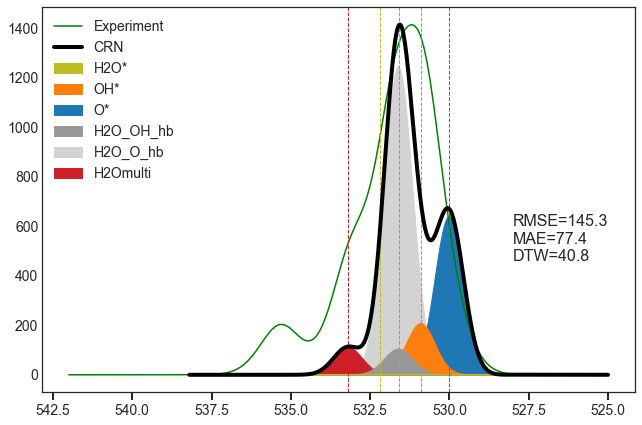

Actual data represented in this figure: 
        BE       XPS       CRN
0    542.0     0.000     0.000
1    541.9     0.000     0.000
2    541.8     0.000     0.000
3    541.7     0.000     0.000
4    541.6     0.000     0.000
5    541.5     0.000     0.000
6    541.4     0.000     0.000
7    541.3     0.000     0.000
8    541.2     0.000     0.000
9    541.1     0.000     0.000
10   541.0     0.000     0.000
11   540.9     0.000     0.000
12   540.8     0.000     0.000
13   540.7     0.000     0.000
14   540.6     0.000     0.000
15   540.5     0.000     0.000
16   540.4     0.000     0.000
17   540.3     0.000     0.000
18   540.2     0.000     0.000
19   540.1     0.000     0.000
20   540.0     0.000     0.000
21   539.9     0.000     0.000
22   539.8     0.000     0.000
23   539.7     0.001     0.000
24   539.6     0.000     0.000
25   539.5     0.000     0.000
26   539.4     0.000     0.000
27   539.3     0.000     0.000
28   539.2     0.000     0.000
29   539.1     0.000     0.00

In [29]:
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 
mse, dtw_cost = s.plot_gaussian(envelope=True, overlay=True, colors=color_dict)
mpl.rc('xtick', labelsize=36) 
mpl.rc('ytick', labelsize=36)

In [30]:
sm = SpeciesManager()

#[535.0 , 532.2 , 530.9 , 530.0 , 531.6 ,  531.6 ,  533.2, 535.0]
#[y1, x2, x3, x4, x53, x54, x6, x7]
#[H2Og, H2O*, OH*, O*, H2O_OH_hb, H2O_O_hb, H2Omulti, O2g]
y1 = sm.sp('H2Og', Orbital('1s', 535.0), 0, {0:1.0000})
x2 = sm.sp('H2O*', Orbital('1s', 532.2), 0, {0:0})
x3 = sm.sp('OH*', Orbital('1s', 530.9), 0, {0:0})
x4 = sm.sp('O*', Orbital('1s', 530.0), 0, {0:0.25})
x53 = sm.sp('H2O_OH_hb', Orbital('1s', 531.6), 0, {0:0})
x54 = sm.sp('H2O_O_hb', Orbital('1s', 531.6), 0, {0:0})
x6 = sm.sp('H2Omulti', Orbital('1s', 533.2), 0, {0:0})
x7 = sm.sp('O2g', Orbital('1s', 535.0), 0, {0:0})

rsys = RxnSystem(
    Rxn(x4 + y1, x54, 3.207654),
    Rxn(x3 + y1, x53, 1.363342),
    RevRxn(x54, x3 + x3, 6.220646,0.160755),
    Rxn(x53, x2 + x3, 0.299507),
    Rxn(x54, x2 + x4, 0.167130),
    Rxn(x2, y1, 1.939313),
    Rxn(y1, x2, 0.515646),
    Rxn(x53, y1 + x3, 0.733491),
    Rxn(x54, x4 + y1, 0.311754),
    Rxn(x53 + y1, x6, 1.038423),
    Rxn(x6, x53 + y1, 0.962999),
    RevRxn(x4 + x4, x7, 0.002342,426.922895),
    sm
)

In [31]:
s = Solution([0], [[0.0022156623108634857], [0.2928109811623684], [0.14350942943370512],
                                           [-1.3603329550499852e-07], [0.37135369150675607], [0.05746675110874676],
                                           [0.0008910289031503243], [0.12109413367954226]], rsys)
s.states = {x53: [0.14350942943370512], x54: [0.0022156623108634857], x6: [0.05746675110874676],
            x7: [-1.3603329550499852e-07], x2: [0.12109413367954226], x4: [0.0008910289031503243], 
            y1: [0.37135369150675607], x3: [0.2928109811623684]}
x = xps.read_new_data('../data/1e-1_rt.txt')
s.set_experimental(x[0])

In [32]:
s.final_state()

{H2O_OH_hb: 0.14350942943370512,
 H2O_O_hb: 0.0022156623108634857,
 H2Omulti: 0.05746675110874676,
 O2g: -1.3603329550499852e-07,
 H2O*: 0.12109413367954226,
 O*: 0.0008910289031503243,
 H2Og: 0.37135369150675607,
 OH*: 0.2928109811623684}

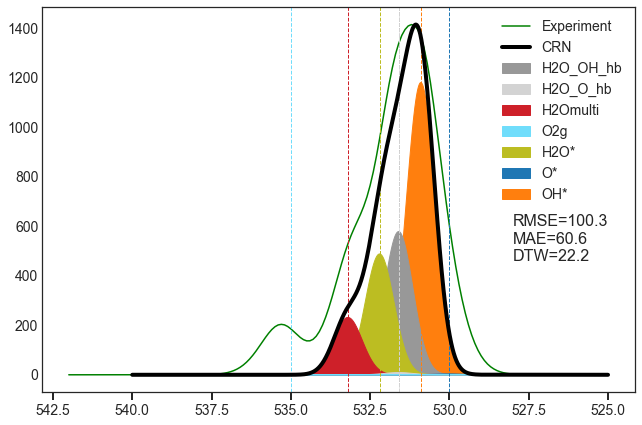

Actual data represented in this figure: 
        BE       XPS       CRN
0    542.0     0.000     0.000
1    541.9     0.000     0.000
2    541.8     0.000     0.000
3    541.7     0.000     0.000
4    541.6     0.000     0.000
5    541.5     0.000     0.000
6    541.4     0.000     0.000
7    541.3     0.000     0.000
8    541.2     0.000     0.000
9    541.1     0.000     0.000
10   541.0     0.000     0.000
11   540.9     0.000     0.000
12   540.8     0.000     0.000
13   540.7     0.000     0.000
14   540.6     0.000     0.000
15   540.5     0.000     0.000
16   540.4     0.000     0.000
17   540.3     0.000     0.000
18   540.2     0.000     0.000
19   540.1     0.000     0.000
20   540.0     0.000    -0.000
21   539.9     0.000    -0.000
22   539.8     0.000    -0.000
23   539.7     0.001    -0.000
24   539.6     0.000    -0.000
25   539.5     0.000    -0.000
26   539.4     0.000    -0.000
27   539.3     0.000    -0.000
28   539.2     0.000    -0.000
29   539.1     0.000    -0.00

In [33]:
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
cyan = "#70ddfb"
color_dict[sm.get_sympy_name("O2g")] = cyan
mse, dtw_cost = s.plot_gaussian(envelope=True, ignore=[y1], overlay=True, colors=color_dict)
mpl.rc('xtick', labelsize=36) 
mpl.rc('ytick', labelsize=36)